# Постановка задачи

Задача иерархической классификации состоит в том, чтобы определить принадлежность объекта к одному или нескольким классам в иерархии. Такой тип классификации сейчас очень актуален, так как для различных с сервисов, имеющих большие каталоги товаров различных категорий, становится важен не только лист, но и путь к листовой категории. Для неверно предсказанных листовых категорий необходимо увеличить оценку качества предсказания, если были угаданы предшествующие родительские категории на разных уровнях.

Цель исследовательской работы: изучить эффективность различых моделей машинного обучения для решения задачи иерархической классификации.

## Используемая метрика

Основываясь на материалы следующей [статьи](https://www.cs.kent.ac.uk/people/staff/aaf/pub_papers.dir/DMKD-J-2010-Silla.pdf), можно выделить следующую формулу, позволяющую вычислять интересующую нас метрику

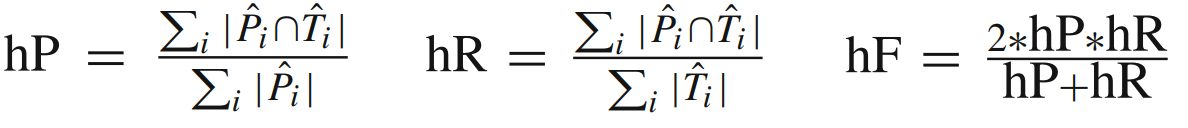

In [1]:
from IPython.display import Image
Image('img/hf1.png', width='60%')

**Pi -** это набор, состоящий из классов, предсказанных для каждого сэмпла i и соотвествующих классов-предков

**Ti -** это набор, состоящий из истинных классов тестового сэмпла i и соотвествующих классов-предков

**hP** - иерархический precision

**hR** - иерархический recall

**hF** - иерархический F1

Следующие примеры позволяют лучше понять, как именно вычисляются иерахические метрики. Для оценки иерархического Precision нам важно оценить насколько точно предсказанные классы совпадают с реальными классами.

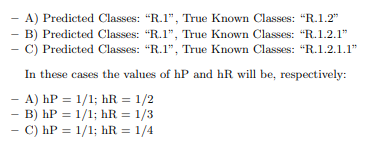

In [2]:
Image('img/hf1_example_1.png', width='60%')

В свою очередь для оценки иерархического Recall важно оценить, сколько спрогнозированных категорий совпадают с реальными категориями

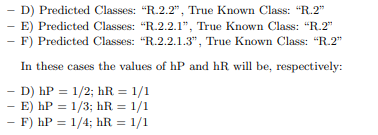

In [3]:
Image('img/hf1_example_2.png', width='60%')

# Поиск и выбор набора данных для проведения исследования

Для проведения исследования был выбран [датасет](https://www.kaggle.com/datasets/kashnitsky/hierarchical-text-classification), содержащий отзывы на продукты интернет-магазина Amazon. В имеющемся наборе данных содержится 6 классов "1 уровня", 66 классов "2 уровня" и 510 классов "3 уровня".

- Классы "1 уровня" - это самые общие категории товаров(health personal care, toys games, beauty, pet supplies, baby products, and grocery gourmet food)
- Классы "2 уровня" - это все подкатегории категорий классов 1 уровня.
- Классы "3 уровня" - это все подкатегории катеорий классов 2 уровня, в данном случае это будет название товара.

Датасет состоит из двух файлов: валидационный набор данных `val_10k.csv` и обучающий набор данных `train_40k.csv`.

# Импорт необходимых библиотек

In [4]:

from tqdm import tqdm
import os
from networkx.drawing.nx_pydot import graphviz_layout
import networkx as nx

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# Загрузка и первичный анализ данных

С помощью средств библиотеки **Pandas** загрузим наши наборы данных.

In [5]:
train_df = pd.read_csv('train_40k.csv').fillna(' ')
valid_df = pd.read_csv('val_10k.csv').fillna(' ')

Посмотрим общую информацию о датасете

In [6]:
train_df.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    40000 non-null  object 
 1   Title        40000 non-null  object 
 2   userId       40000 non-null  object 
 3   Helpfulness  40000 non-null  object 
 4   Score        40000 non-null  float64
 5   Time         40000 non-null  int64  
 6   Text         40000 non-null  object 
 7   Cat1         40000 non-null  object 
 8   Cat2         40000 non-null  object 
 9   Cat3         40000 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.1+ MB


В имеющемся датасете 10 колонок и 40000 записей

**Признаки:**

* `productId` – идентификатор продукта, на который написан отзыв
* `Title` - заголовок отзыва
* `user` - идентификатор автора отзыва
* `Helpfulness` - сколько пользователей посчитали этот отзыв полезным
* `Score` - оценка отзыва другими пользователями
* `Time` - время публикации отзыва
* `Text` - текст отзыва

**Целевые признаки**

* `Cat1` - Классы "1 уровня"
* `Cat2` - Классы "2 уровня"
* `Cat3` - Классы "3 уровня"

Визуализируем граф категорий для этого:

- создадим датафрейм из двух колонок, в одной родительские категория, в другой его подкатегория
- создадим граф
- сгенерируем список предков
- построим граф категорий, опираясь на списки предков

In [8]:
df = train_df.copy(['Cat1', 'Cat2', 'Cat3'])
df = df[['Cat1', 'Cat2', 'Cat3']]
df_2 = pd.concat([df['Cat1'], df['Cat2']])
df_3 = pd.concat([df['Cat2'], df['Cat3']])
cols = ['a','b']
frame = {'par' :  df_2, 'child' : df_3}
df = pd.DataFrame(frame)

In [9]:
DG = nx.DiGraph()
G = nx.Graph()  #  костыль, т.к. для направленного графа не рисует деревья. Not Implemented

for k, v in tqdm(df.iterrows()):
    DG.add_edge(v['par'], v['child'], weight=1)
    G.add_edge(v['par'], v['child'], weight=1)

print("Всего уникальных вершин: {0}".format(len(DG.nodes)))

80000it [00:05, 15354.79it/s]

Всего уникальных вершин: 523


In [10]:
def all_predcestors(g, id, max_len=6):
    # циклично запрашиваем предков, пока их не будет совсем
    all_preds = [id]
    while True:
        preds = list(g.predecessors(id))
        if len(preds) == 0:
            break
        all_preds.append(preds[0])
        id = all_preds[-1]
    return all_preds[::-1]

In [11]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

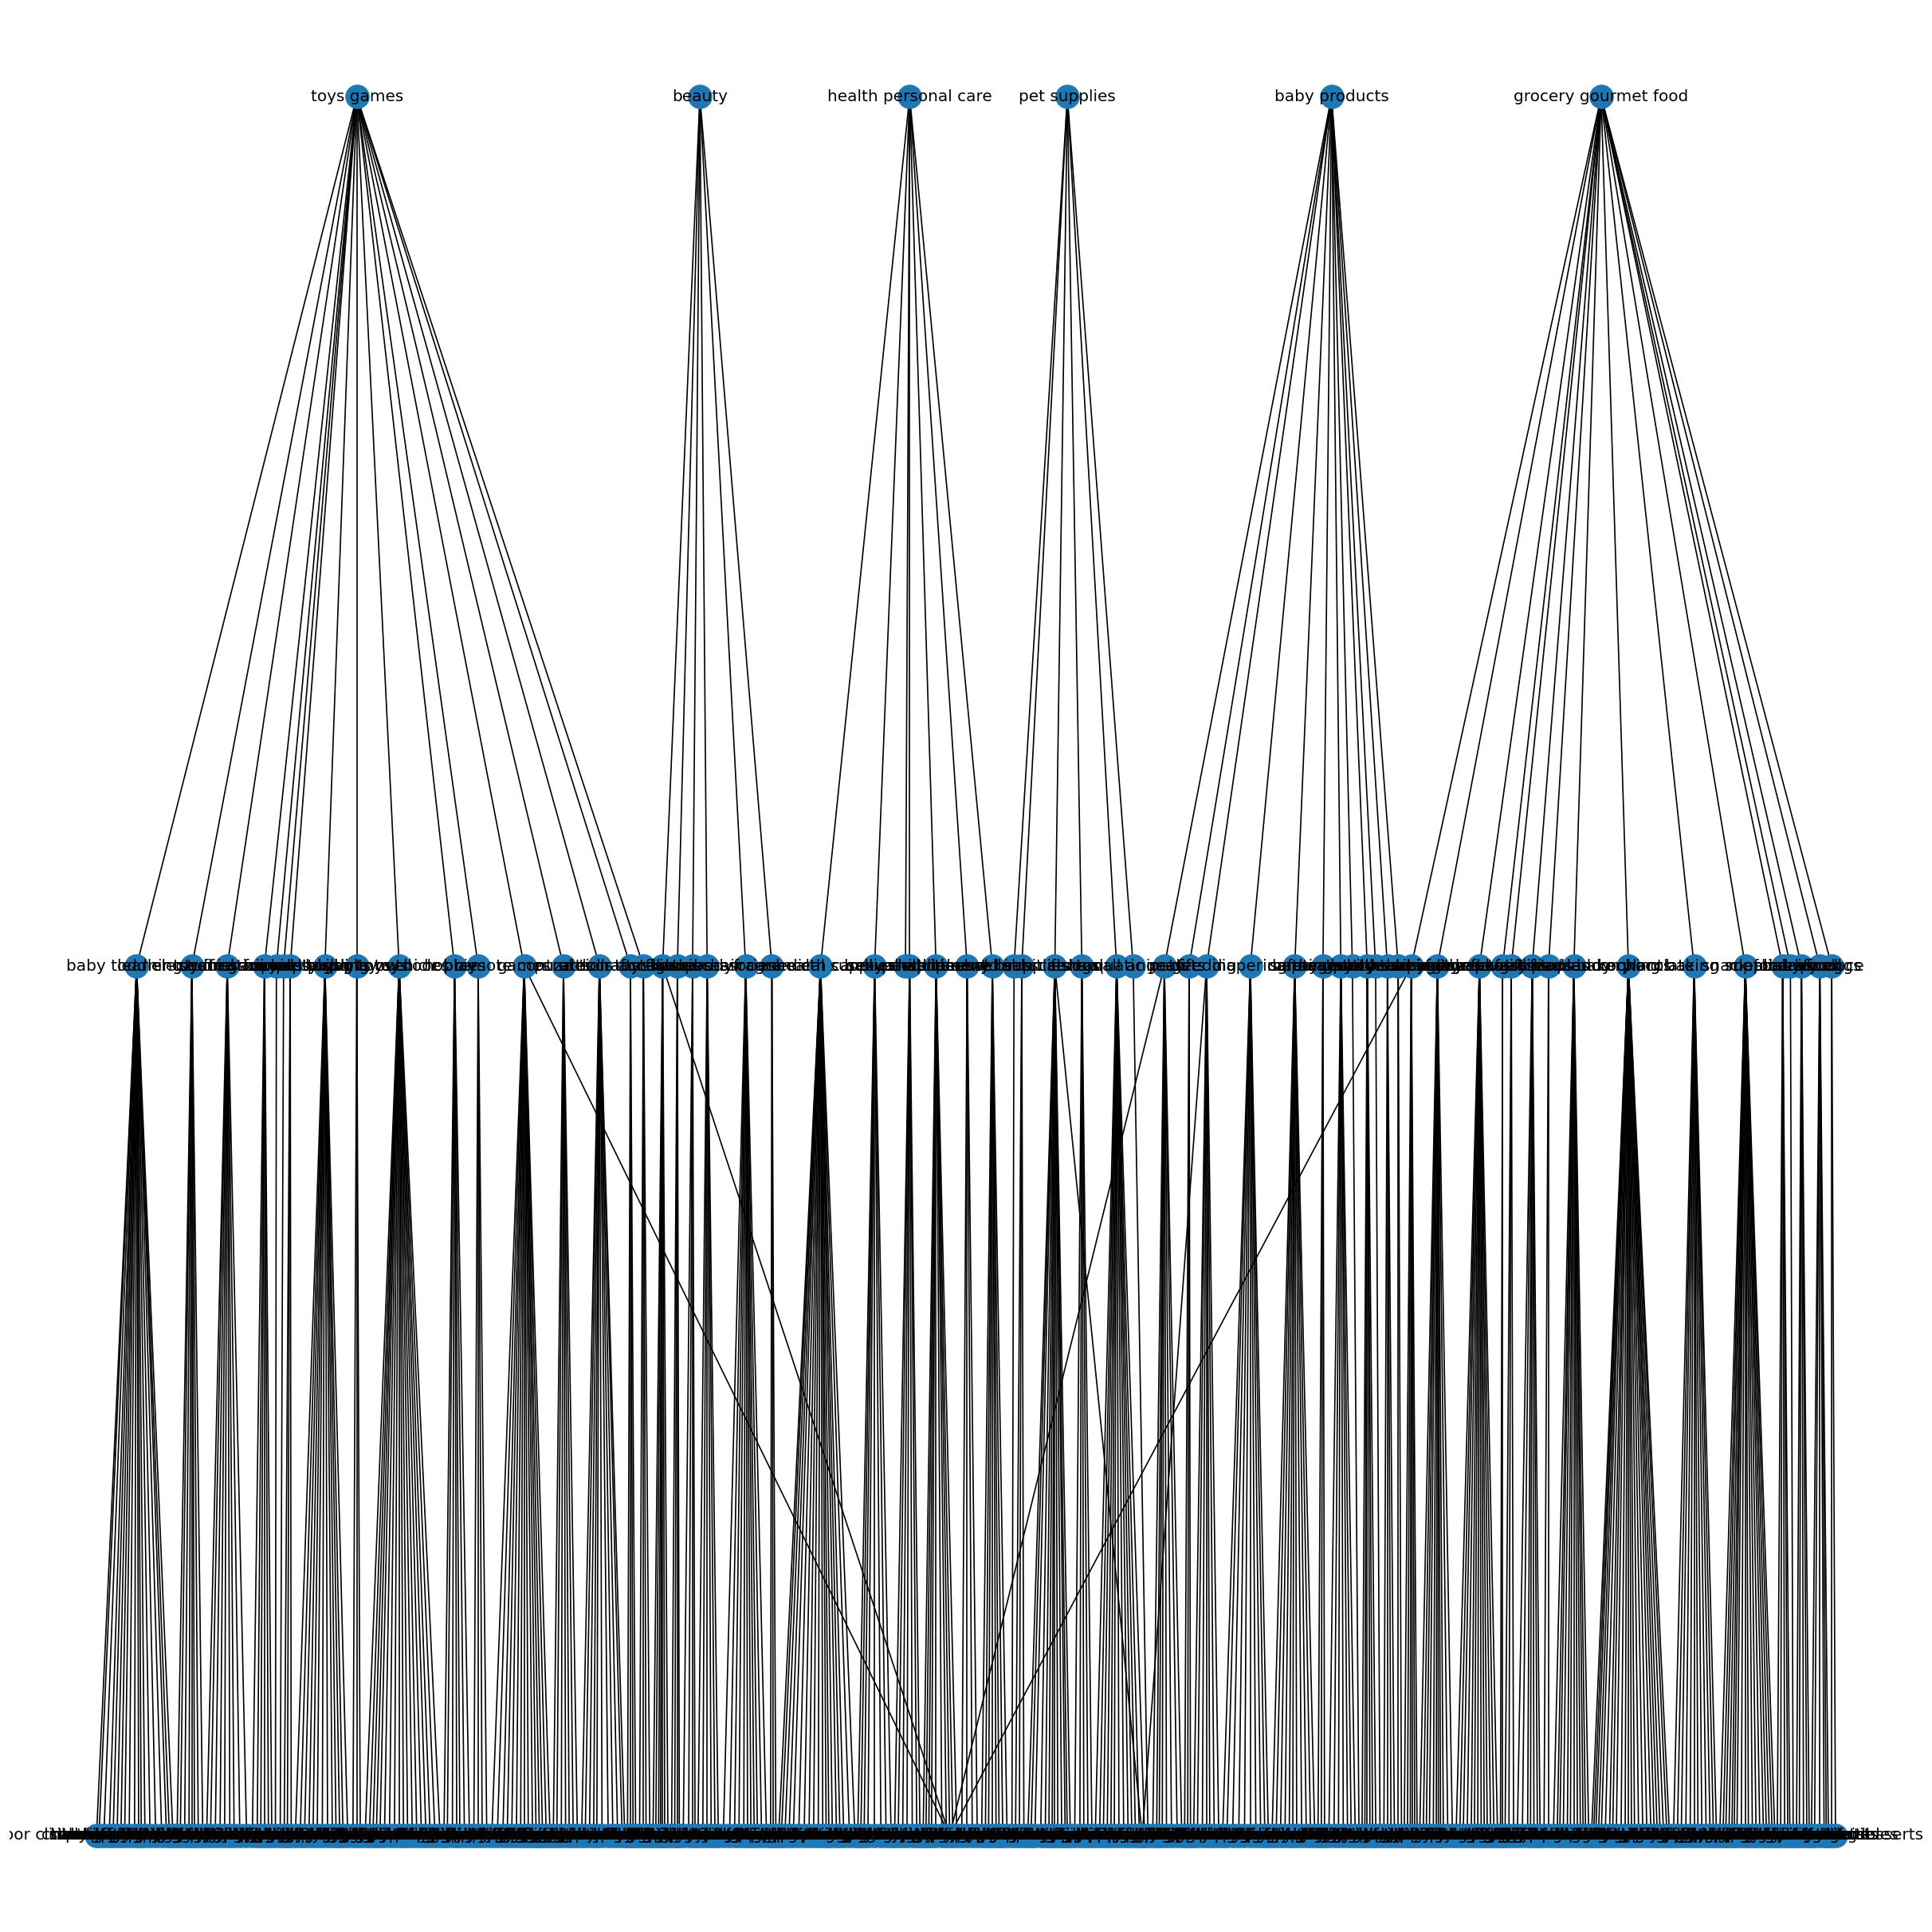

In [12]:
T = nx.maximum_spanning_tree(G)
plt.figure(figsize=(20,20), dpi=60)
pos = graphviz_layout(T,prog='dot')
top = 500
step = 50
first_pad = 50
new_pos = {}
for k, v in pos.items():
    v1, v2 = v
    v2 = top - (len(all_predcestors(DG, k)) * step + first_pad)
    new_pos[k] = (v1, v2)

nx.draw(T, new_pos, with_labels=True, font_weight='normal')
plt.show()

Посмотрим на то, как в записи связан текст отзыва и конечные категории

In [13]:
train_df.loc[0, 'Text']

'The description and photo on this product needs to be changed to indicate this product is the BuffalOs version of this beef jerky.'

In [14]:
train_df.loc[0, 'Cat1'], train_df.loc[0, 'Cat2'], train_df.loc[0, 'Cat3']

('grocery gourmet food', 'meat poultry', 'jerky')

Оценим распределение категорий

In [15]:
train_df['Cat1'].value_counts()

toys games              10266
health personal care     9772
beauty                   5846
baby products            5637
pet supplies             4862
grocery gourmet food     3617
Name: Cat1, dtype: int64

Создадим единый целевой признак

In [16]:
train_df['Cat1_Cat2_Cat3'] = train_df['Cat1'] + '/' + train_df['Cat2'] + '/' + train_df['Cat3']
valid_df['Cat1_Cat2_Cat3'] = valid_df['Cat1'] + '/' + valid_df['Cat2'] + '/' + valid_df['Cat3']

In [17]:
train_df['Cat1_Cat2_Cat3'].nunique()

555

Теперь у нас 555 уникальных классов, посмотрим, как они распределены

In [18]:
train_df['Cat1_Cat2_Cat3'].value_counts().head()

health personal care/personal care/shaving hair removal         1565
health personal care/nutrition wellness/vitamins supplements    1315
toys games/games/board games                                     924
beauty/hair care/styling tools                                   850
beauty/fragrance/women s                                         737
Name: Cat1_Cat2_Cat3, dtype: int64

# Обучение моделей

Используя средства библиотеки sklearn создадим pipeline из модели и TF-IDF векторизатора. Он нужен для интрепритацией модели категориальных текстовых признаков. Для визуализации работы модели используем функцию построения матрицы ошибок. Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного отзыва и с низкой частотой употреблений в других отзывах.

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    import itertools
    cm = confusion_matrix(y_true, y_pred).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

Напишем функцию для вычисления искомой метрики.

В силу особенности датасета(у каждого товара всегда есть гарантированные 2 родительские категории), функция была упрощена.

In [20]:
def hf1_score(df1):
    score=0
    hP = 0
    hR = 0
    for index in range(0, df1.shape[0]):
        if df1.at[index, 'Cat1'] == valid_df.at[index, 'Cat1']:
            score += 1
        if df1.at[index, 'Cat2'] == valid_df.at[index, 'Cat2']:
            score += 1
        if df1.at[index, 'Cat2'] == valid_df.at[index, 'Cat3']:
            score += 1
        score = score / 3
    hP += score 
    hR += score 
    hF1 = (2 * hP * hR) / (hP + hR)
    return hF1

Создадим словари для хранения результатов оценки различными метриками

In [21]:
results_Cat1 = {}
results_Cat2 = {}
results_Cat3 = {}
results_hF1 = {}

## Логистическая регрессия

In [22]:
tf_idf = TfidfVectorizer(max_features=50000, min_df=2)

logit = LogisticRegression(C=1e2, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=0, 
                           multi_class='multinomial',
                           fit_intercept=True)

tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [23]:
%%time
tfidf_logit_pipeline.fit(train_df['Title'], train_df['Cat1_Cat2_Cat3'])

Wall time: 2min 26s


Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=50000, min_df=2)),
                ('logit',
                 LogisticRegression(C=100.0, multi_class='multinomial',
                                    n_jobs=4, random_state=17))])

In [24]:
%%time
valid_pred_level_3 = tfidf_logit_pipeline.predict(valid_df['Title'])

Wall time: 130 ms


In [25]:
valid_pred_level_1 = [el.split('/')[0] for el in valid_pred_level_3]
valid_pred_level_2 = [el.split('/')[1] for el in valid_pred_level_3]
valid_pred_level_3 = [el.split('/')[2] for el in valid_pred_level_3]

In [26]:
print("Level 1:\n\tF1 : {}\n\t".format(
    f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)))

Level 1:
	F1 : 0.946
	


In [27]:
print("Level 2:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)))

Level 2:
	F1 : 0.886


In [28]:
print("Level 3:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)))

Level 3:
	F1 : 0.854


In [29]:
prepared_dict = {'Cat1' : valid_pred_level_1, 'Cat2' : valid_pred_level_2, 'Cat3' : valid_pred_level_3}
prepared_df = pd.DataFrame(prepared_dict)
print("All Levels:\n\thF1 : {}".format(
    round(hf1_score(prepared_df), 3)))

All Levels:
	hF1 : 0.997


Запишем полученные результаты

In [30]:
results_Cat1['LogReg'] = f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)
results_Cat2['LogReg'] = f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)
results_Cat3['LogReg'] = f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)
results_hF1['LogReg'] = round(hf1_score(prepared_df), 3)

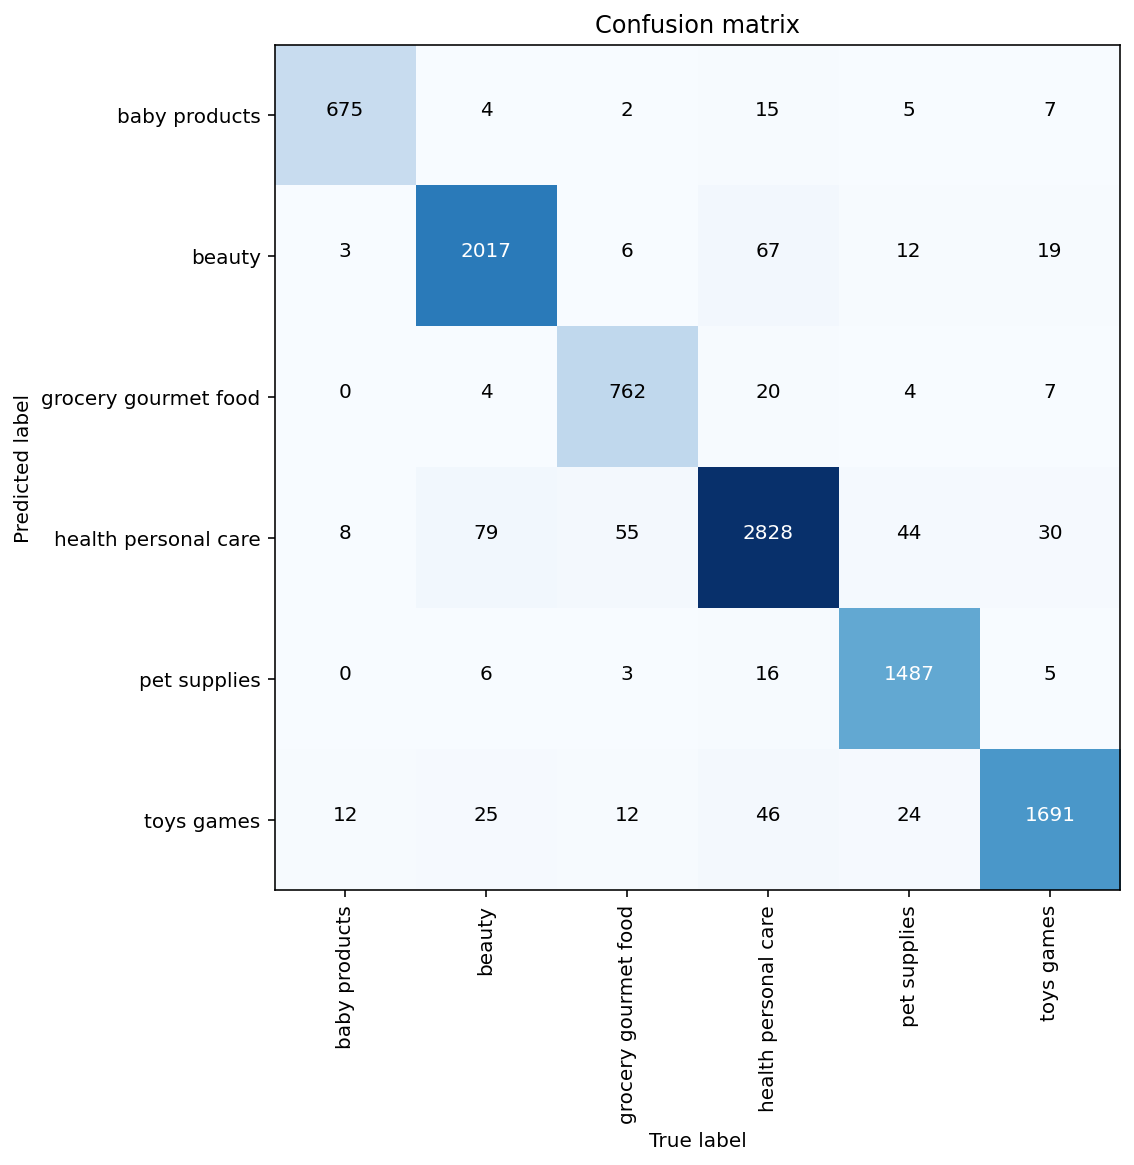

In [31]:
plot_confusion_matrix(
    y_true=valid_df['Cat1'],
    y_pred=valid_pred_level_1, 
    classes=sorted(train_df['Cat1'].unique()),
    figsize=(8, 8)
)

## Решающее дерево

In [32]:
tf_idf = TfidfVectorizer(max_features=10000, min_df=2)

dectr = DecisionTreeClassifier(random_state=17, max_depth=1200, min_samples_split=2, min_samples_leaf=1)

tfidf_dectr_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('dectr', dectr)])

In [33]:
%%time
tfidf_dectr_pipeline.fit(train_df['Title'], train_df['Cat1_Cat2_Cat3'])

Wall time: 31.9 s


Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=10000, min_df=2)),
                ('dectr',
                 DecisionTreeClassifier(max_depth=1200, random_state=17))])

In [34]:
%%time
valid_pred_level_3 = tfidf_dectr_pipeline.predict(valid_df['Title'])

Wall time: 89.2 ms


In [35]:
valid_pred_level_1 = [el.split('/')[0] for el in valid_pred_level_3]
valid_pred_level_2 = [el.split('/')[1] for el in valid_pred_level_3]
valid_pred_level_3 = [el.split('/')[2] for el in valid_pred_level_3]

In [36]:
print("Level 1:\n\tF1 : {}\n\t".format(
    f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)))

Level 1:
	F1 : 0.881
	


In [37]:
print("Level 2:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)))

Level 2:
	F1 : 0.806


In [38]:
print("Level 3:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)))

Level 3:
	F1 : 0.774


In [39]:
prepared_dict = {'Cat1' : valid_pred_level_1, 'Cat2' : valid_pred_level_2, 'Cat3' : valid_pred_level_3}
prepared_df = pd.DataFrame(prepared_dict)
print("All Levels:\n\thF1 : {}".format(
    round(hf1_score(prepared_df), 3)))

All Levels:
	hF1 : 0.974


In [40]:
results_Cat1['DecTree'] = f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)
results_Cat2['DecTree'] = f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)
results_Cat3['DecTree'] = f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)
results_hF1['DecTree'] = round(hf1_score(prepared_df), 3)

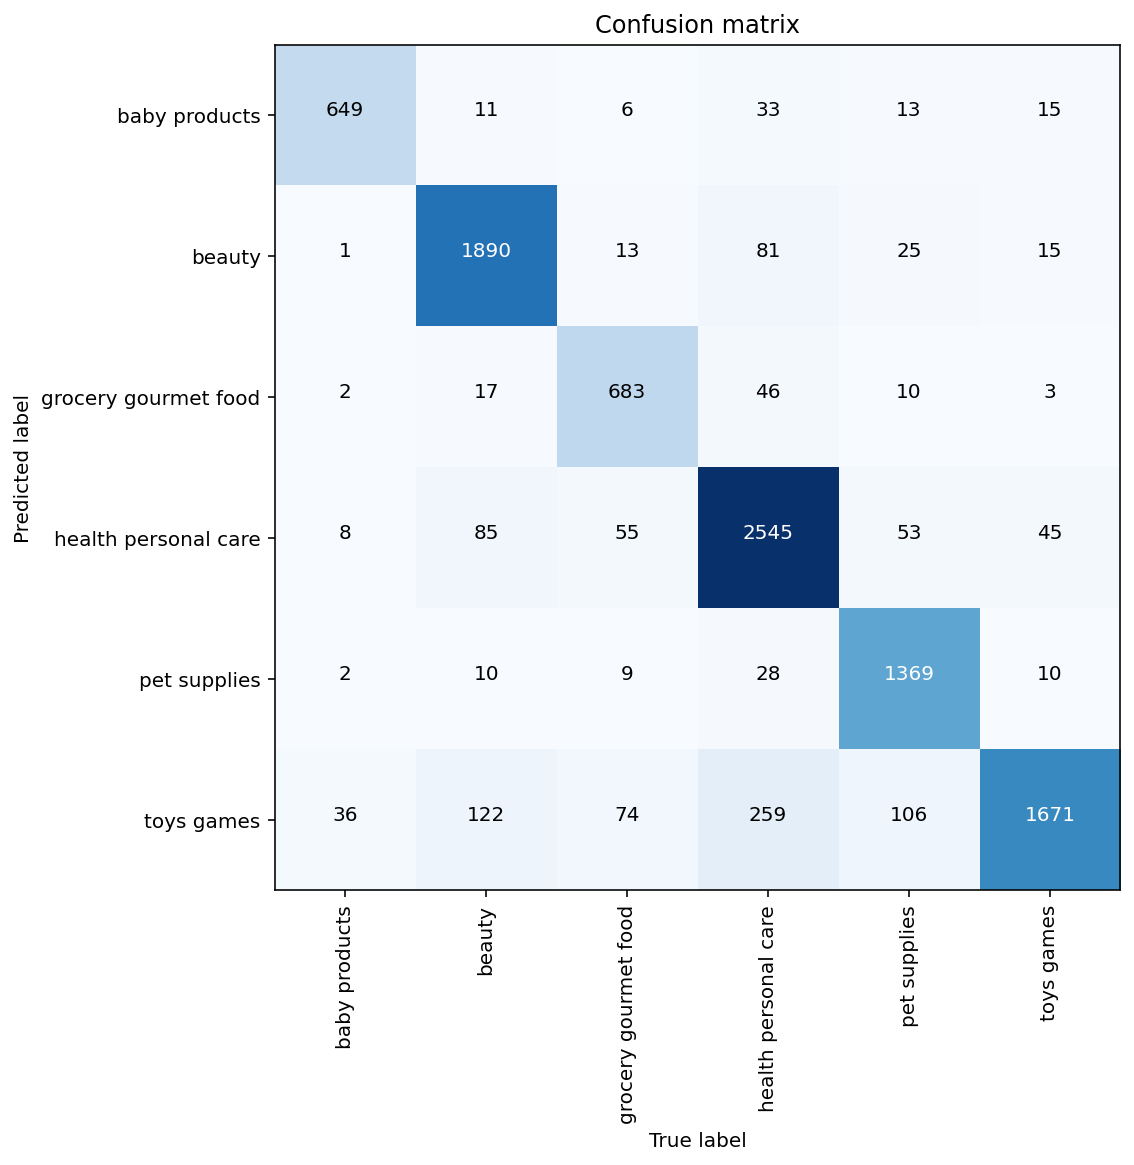

In [41]:
plot_confusion_matrix(
    y_true=valid_df['Cat1'],
    y_pred=valid_pred_level_1, 
    classes=sorted(train_df['Cat1'].unique()),
    figsize=(8, 8)
)

## Случайный лес

In [42]:
tf_idf = TfidfVectorizer(max_features=3500, min_df=2)

randfor = RandomForestClassifier(random_state=17, max_depth=700,
                                 min_samples_leaf=1, min_samples_split=2, criterion='entropy')

tfidf_randfor_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('randfor', randfor)])

In [43]:
%%time
tfidf_randfor_pipeline.fit(train_df['Title'], train_df['Cat1_Cat2_Cat3'])

Wall time: 2min 1s


Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=3500, min_df=2)),
                ('randfor',
                 RandomForestClassifier(criterion='entropy', max_depth=700,
                                        random_state=17))])

In [44]:
%%time
valid_pred_level_3 = tfidf_randfor_pipeline.predict(valid_df['Title'])

Wall time: 3.74 s


In [45]:
valid_pred_level_1 = [el.split('/')[0] for el in valid_pred_level_3]
valid_pred_level_2 = [el.split('/')[1] for el in valid_pred_level_3]
valid_pred_level_3 = [el.split('/')[2] for el in valid_pred_level_3]

In [46]:
print("Level 1:\n\tF1 : {}\n\t".format(
    f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)))

Level 1:
	F1 : 0.896
	


In [47]:
print("Level 2:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)))

Level 2:
	F1 : 0.821


In [48]:
print("Level 3:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)))

Level 3:
	F1 : 0.789


In [49]:
prepared_dict = {'Cat1' : valid_pred_level_1, 'Cat2' : valid_pred_level_2, 'Cat3' : valid_pred_level_3}
prepared_df = pd.DataFrame(prepared_dict)
print("All Levels:\n\thF1 : {}".format(
    round(hf1_score(prepared_df), 3)))

All Levels:
	hF1 : 0.664


In [50]:
results_Cat1['RandForest'] = f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)
results_Cat2['RandForest'] = f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)
results_Cat3['RandForest'] = f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)
results_hF1['RandForest'] = round(hf1_score(prepared_df), 3)

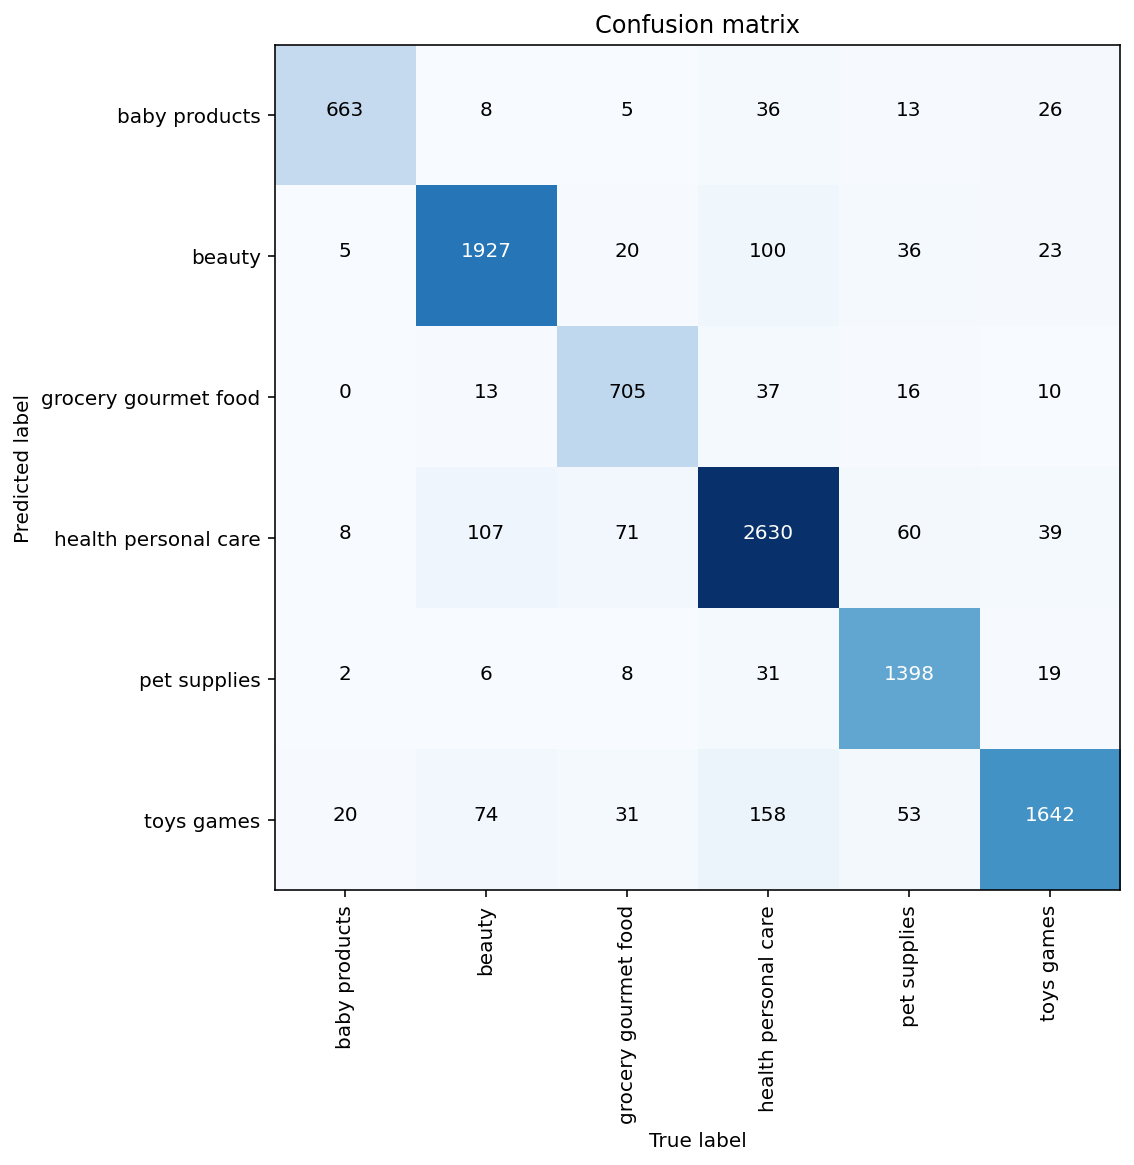

In [51]:
plot_confusion_matrix(
    y_true=valid_df['Cat1'],
    y_pred=valid_pred_level_1, 
    classes=sorted(train_df['Cat1'].unique()),
    figsize=(8, 8)
)

## Метод опорных векторов

In [52]:
tf_idf = TfidfVectorizer(max_features=50000, min_df=2)

svm = LinearSVC(random_state=17, C=1e2, max_iter=1500)

tfidf_svm_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('randfor', randfor)])

In [53]:
%%time
tfidf_svm_pipeline.fit(train_df['Title'], train_df['Cat1_Cat2_Cat3'])

Wall time: 2min 1s


Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=50000, min_df=2)),
                ('randfor',
                 RandomForestClassifier(criterion='entropy', max_depth=700,
                                        random_state=17))])

In [54]:
%%time
valid_pred_level_3 = tfidf_svm_pipeline.predict(valid_df['Title'])

Wall time: 3.85 s


In [55]:
valid_pred_level_1 = [el.split('/')[0] for el in valid_pred_level_3]
valid_pred_level_2 = [el.split('/')[1] for el in valid_pred_level_3]
valid_pred_level_3 = [el.split('/')[2] for el in valid_pred_level_3]

In [56]:
print("Level 1:\n\tF1 : {}\n\t".format(
    f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)))

Level 1:
	F1 : 0.907
	


In [57]:
print("Level 2:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)))

Level 2:
	F1 : 0.836


In [58]:
print("Level 3:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)))

Level 3:
	F1 : 0.805


In [59]:
prepared_dict = {'Cat1' : valid_pred_level_1, 'Cat2' : valid_pred_level_2, 'Cat3' : valid_pred_level_3}
prepared_df = pd.DataFrame(prepared_dict)
print("All Levels:\n\thF1 : {}".format(
    round(hf1_score(prepared_df), 3)))

All Levels:
	hF1 : 0.664


In [60]:
results_Cat1['SVM'] = f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)
results_Cat2['SVM'] = f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)
results_Cat3['SVM'] = f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)
results_hF1['SVM'] = round(hf1_score(prepared_df), 3)

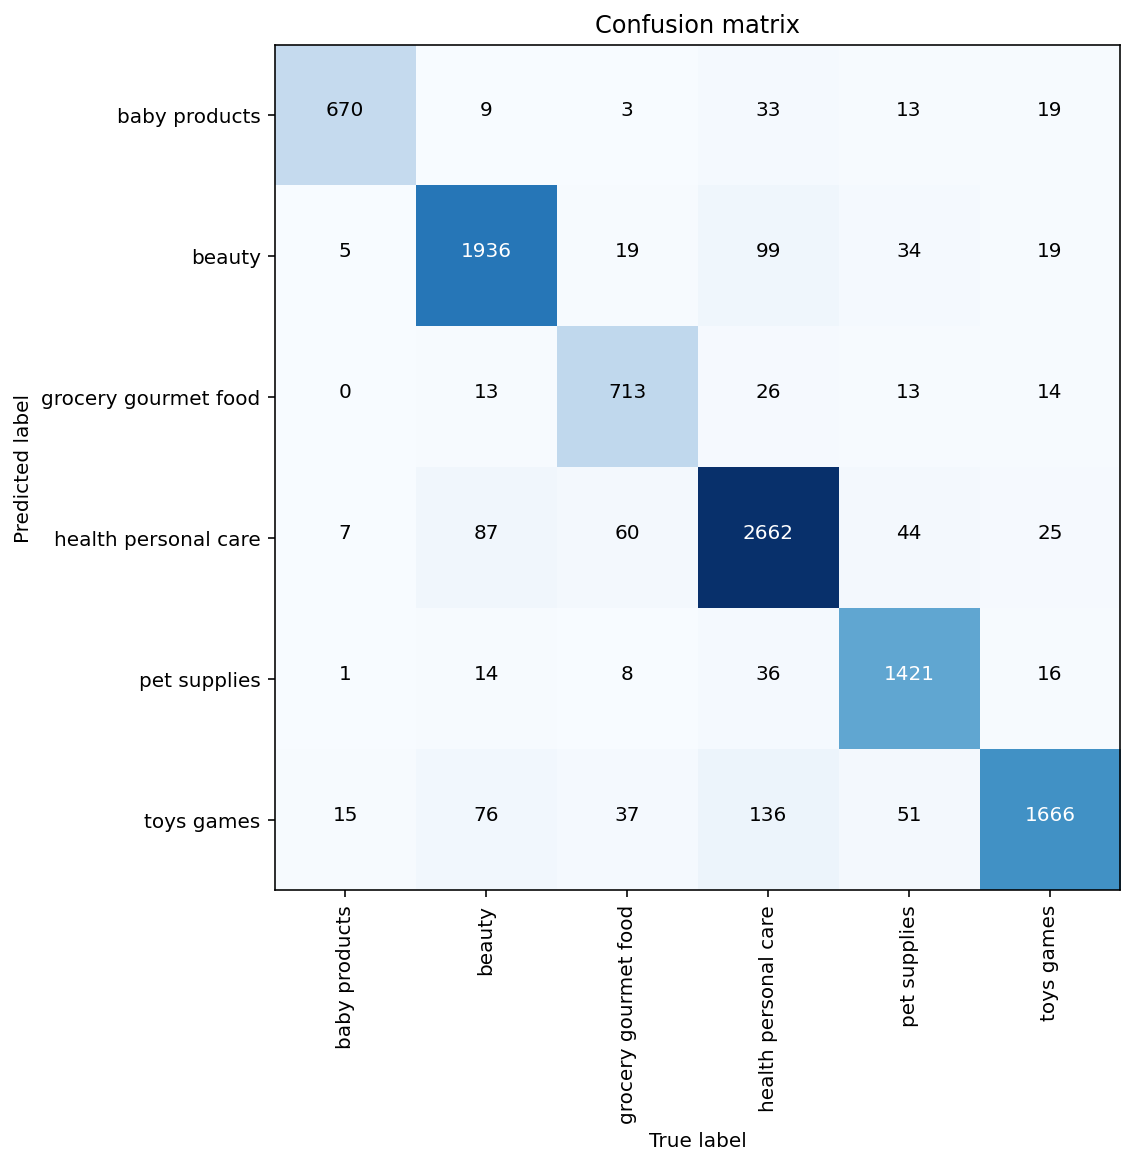

In [61]:
plot_confusion_matrix(
    y_true=valid_df['Cat1'],
    y_pred=valid_pred_level_1, 
    classes=sorted(train_df['Cat1'].unique()),
    figsize=(8, 8)
)

## Naive Bayes

In [62]:
tf_idf = TfidfVectorizer(max_features=50000, min_df=2)

multiNB = MultinomialNB(alpha=0, fit_prior=True)

tfidf_multiNB_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('multiNB', multiNB)])

In [63]:
%%time
tfidf_multiNB_pipeline.fit(train_df['Title'], train_df['Cat1_Cat2_Cat3'])

Wall time: 1.28 s


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=50000, min_df=2)),
                ('multiNB', MultinomialNB(alpha=0))])

In [64]:
%%time
valid_pred_level_3 = tfidf_multiNB_pipeline.predict(valid_df['Title'])

Wall time: 149 ms


In [65]:
valid_pred_level_1 = [el.split('/')[0] for el in valid_pred_level_3]
valid_pred_level_2 = [el.split('/')[1] for el in valid_pred_level_3]
valid_pred_level_3 = [el.split('/')[2] for el in valid_pred_level_3]

In [66]:
print("Level 1:\n\tF1 : {}\n\t".format(
    f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)))

Level 1:
	F1 : 0.884
	


In [67]:
print("Level 2:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)))

Level 2:
	F1 : 0.815


In [68]:
print("Level 3:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)))

Level 3:
	F1 : 0.777


In [69]:
prepared_dict = {'Cat1' : valid_pred_level_1, 'Cat2' : valid_pred_level_2, 'Cat3' : valid_pred_level_3}
prepared_df = pd.DataFrame(prepared_dict)
print("All Levels:\n\thF1 : {}".format(
    round(hf1_score(prepared_df), 3)))

All Levels:
	hF1 : 0.332


In [70]:
results_Cat1['NB'] = f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)
results_Cat2['NB'] = f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)
results_Cat3['NB'] = f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)
results_hF1['NB'] = round(hf1_score(prepared_df), 3)

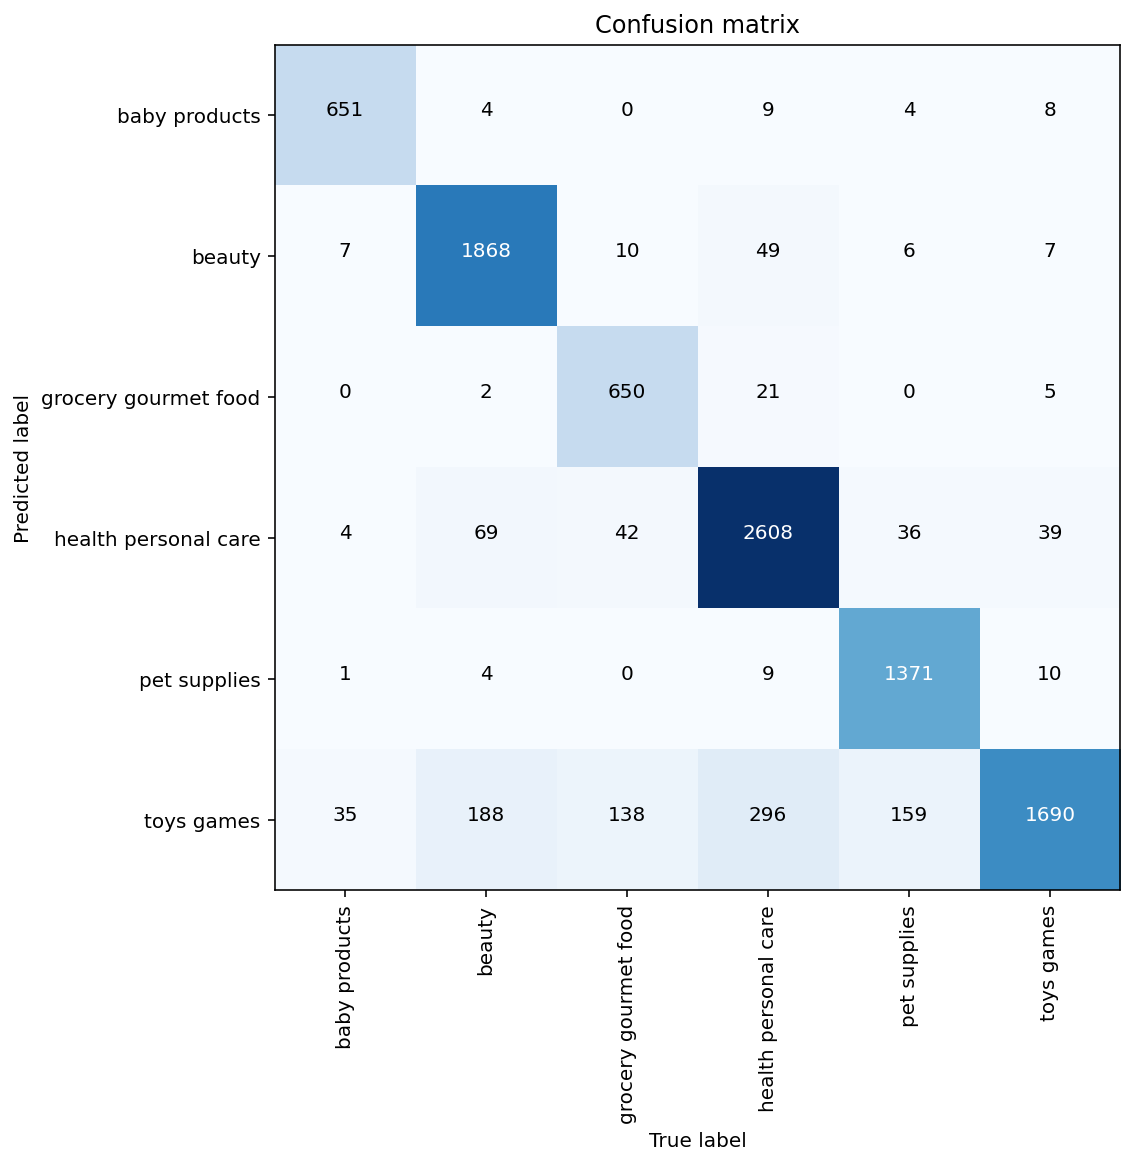

In [71]:
plot_confusion_matrix(
    y_true=valid_df['Cat1'],
    y_pred=valid_pred_level_1, 
    classes=sorted(train_df['Cat1'].unique()),
    figsize=(8, 8)
)

## Метод ближайших соседей

In [72]:
tf_idf = TfidfVectorizer(max_features=50000, min_df=2)

knn = KNeighborsClassifier(n_neighbors=1)

tfidf_knn_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('knn', knn)])

In [73]:
%%time
tfidf_knn_pipeline.fit(train_df['Title'], train_df['Cat1_Cat2_Cat3'])

Wall time: 344 ms


Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=50000, min_df=2)),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

In [74]:
%%time
valid_pred_level_3 = tfidf_knn_pipeline.predict(valid_df['Title'])

Wall time: 10.2 s


In [75]:
valid_pred_level_1 = [el.split('/')[0] for el in valid_pred_level_3]
valid_pred_level_2 = [el.split('/')[1] for el in valid_pred_level_3]
valid_pred_level_3 = [el.split('/')[2] for el in valid_pred_level_3]

In [76]:
print("Level 1:\n\tF1 : {}\n\t".format(
    f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)))

Level 1:
	F1 : 0.871
	


In [77]:
print("Level 2:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)))

Level 2:
	F1 : 0.805


In [78]:
print("Level 3:\n\tF1 : {}".format(
    f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)))

Level 3:
	F1 : 0.778


In [79]:
prepared_dict = {'Cat1' : valid_pred_level_1, 'Cat2' : valid_pred_level_2, 'Cat3' : valid_pred_level_3}
prepared_df = pd.DataFrame(prepared_dict)
print("All Levels:\n\thF1 : {}".format(
    round(hf1_score(prepared_df), 3)))

All Levels:
	hF1 : 0.331


In [80]:
results_Cat1['KNN'] = f1_score(y_true=valid_df['Cat1'], y_pred=valid_pred_level_1, average='micro').round(3)
results_Cat2['KNN'] = f1_score(y_true=valid_df['Cat2'], y_pred=valid_pred_level_2, average='micro').round(3)
results_Cat3['KNN'] = f1_score(y_true=valid_df['Cat3'], y_pred=valid_pred_level_3, average='micro').round(3)
results_hF1['KNN'] = round(hf1_score(prepared_df), 3)

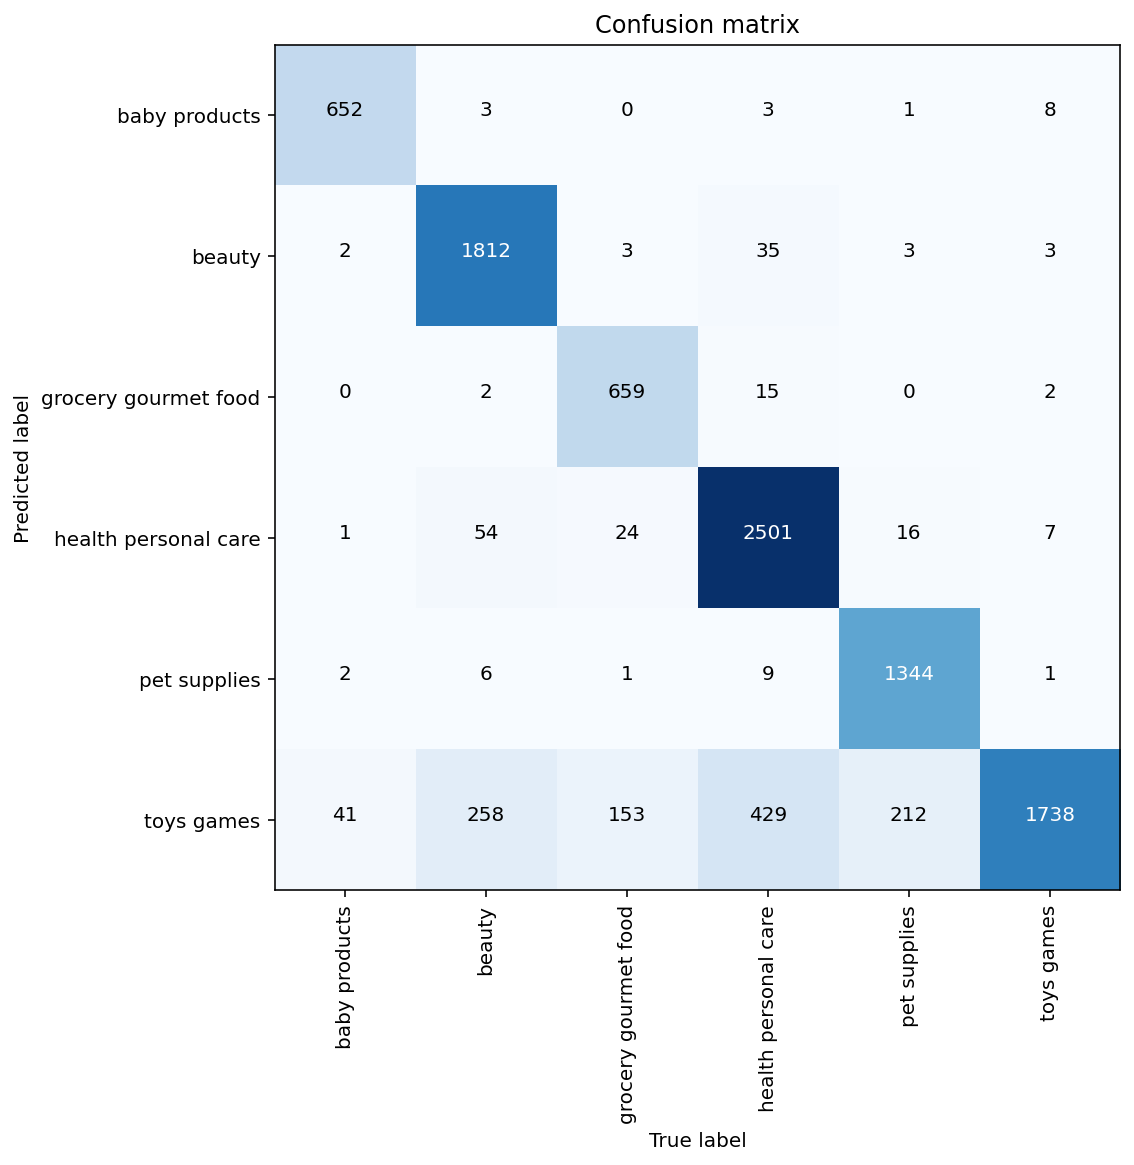

In [81]:
plot_confusion_matrix(
    y_true=valid_df['Cat1'],
    y_pred=valid_pred_level_1, 
    classes=sorted(train_df['Cat1'].unique()),
    figsize=(8, 8)
)

# Сравнение результатов

Для начала построим графики каждой оценок метрики F1 для качества предсказаний по каждому уровню

<AxesSubplot:title={'center':'F1 per Category 1'}>

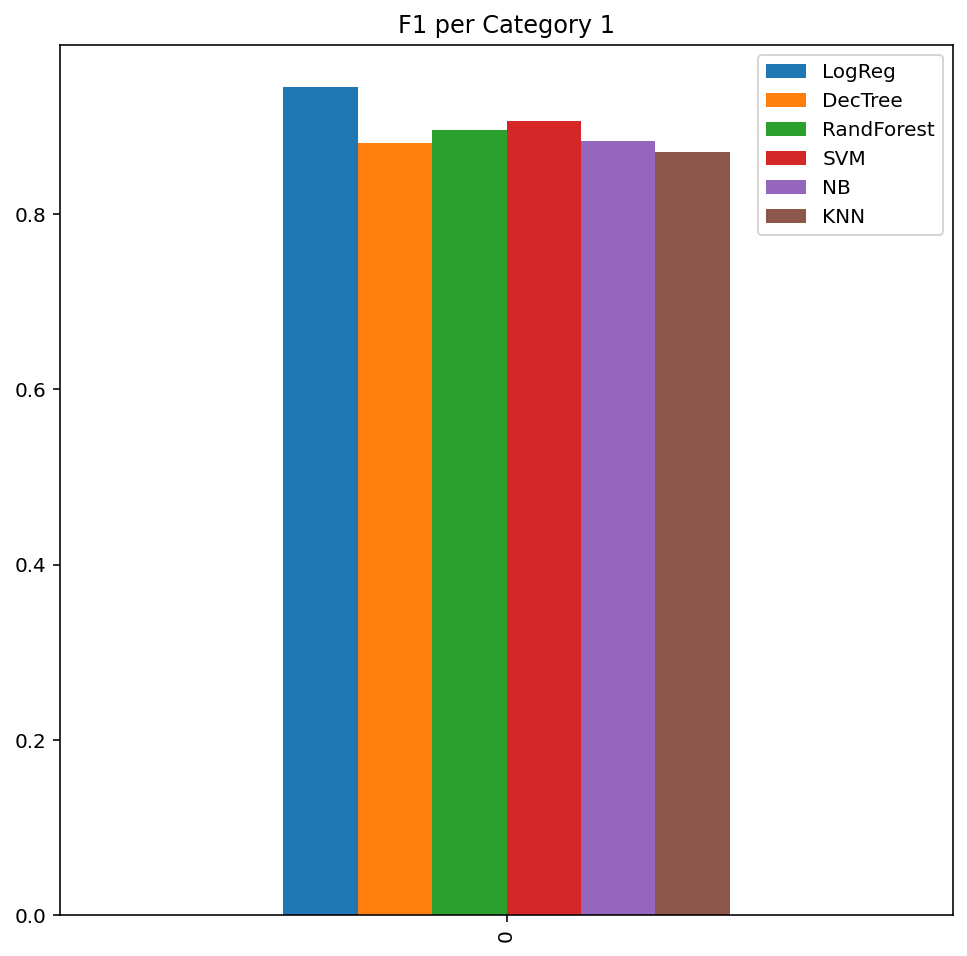

In [82]:
pd.DataFrame([results_Cat1]).plot(y=['LogReg', 'DecTree', 'RandForest', 'SVM', 'NB', 'KNN'],
                                  kind='bar',
                                  figsize=(8,8),
                                  title='F1 per Category 1')

<AxesSubplot:title={'center':'F1 per Category 2'}>

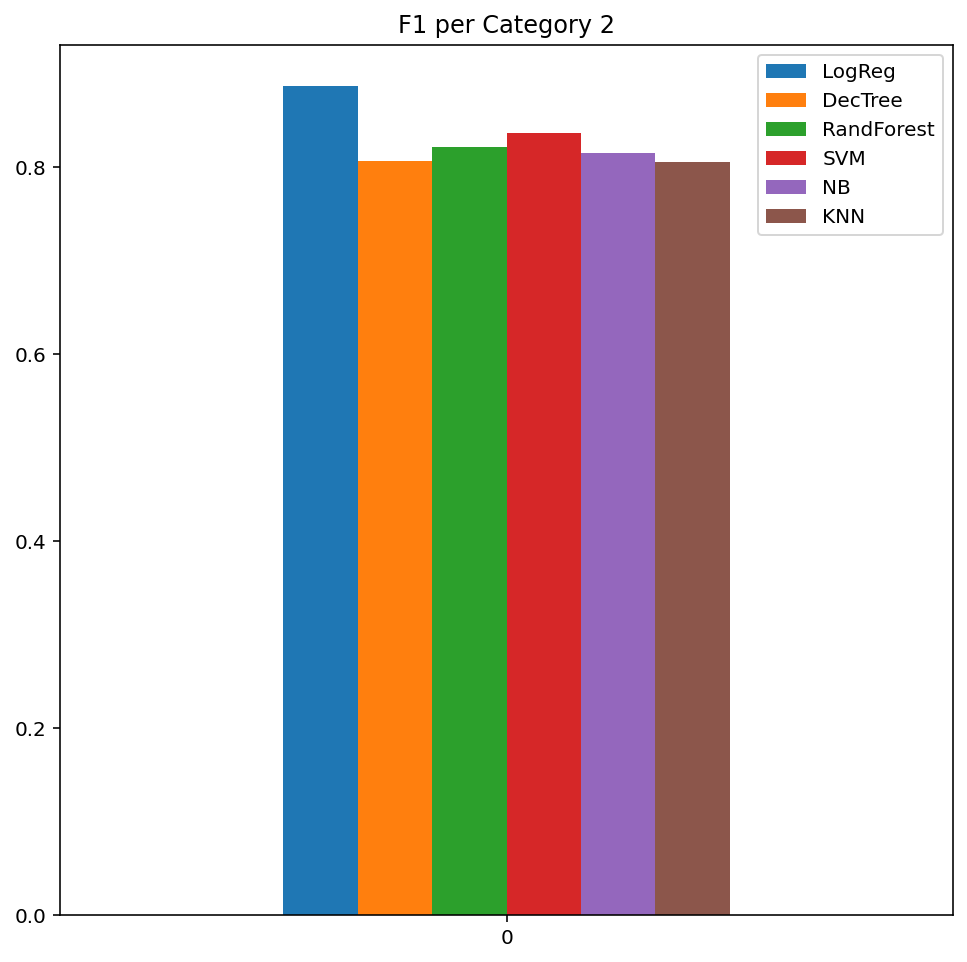

In [83]:
pd.DataFrame([results_Cat2]).plot(y=['LogReg', 'DecTree', 'RandForest', 'SVM', 'NB', 'KNN'],
                                  kind='bar',
                                  rot=0,
                                  figsize=(8,8),
                                  title='F1 per Category 2')

<AxesSubplot:title={'center':'F1 per Category 3'}>

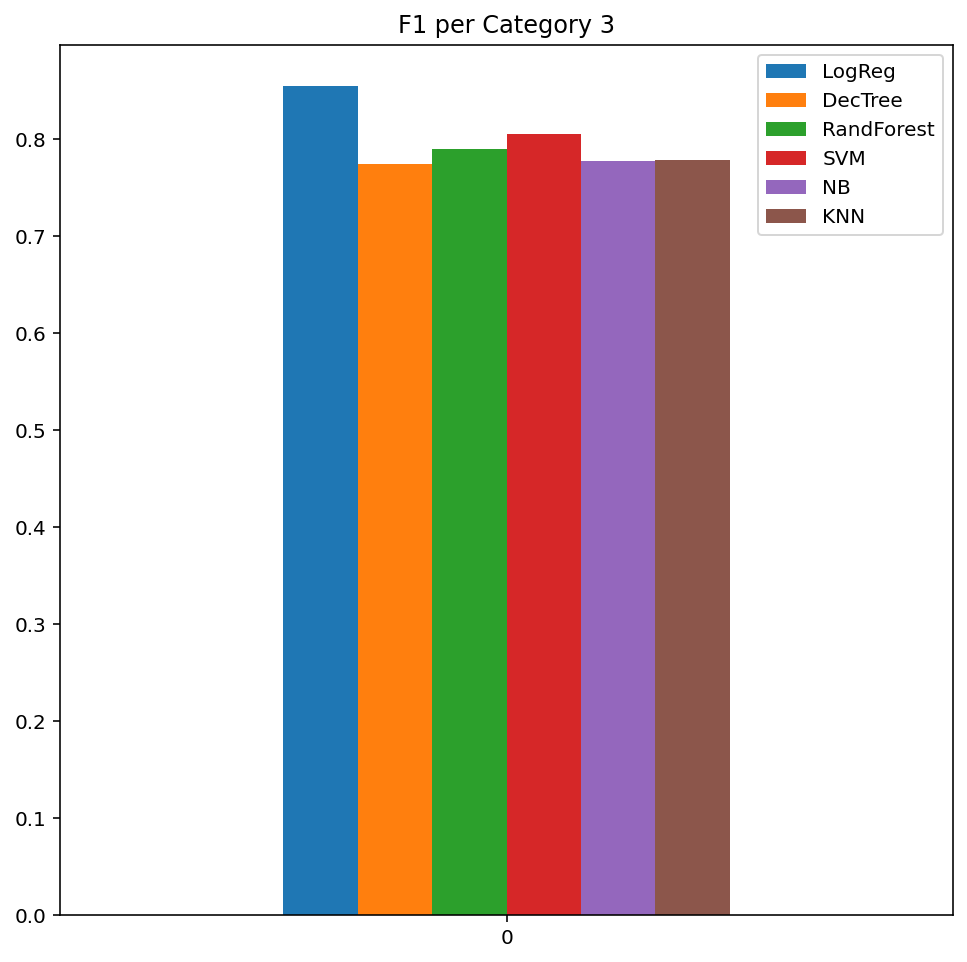

In [84]:
pd.DataFrame([results_Cat3]).plot(y=['LogReg', 'DecTree', 'RandForest', 'SVM', 'NB', 'KNN'],
                                  kind='bar',
                                  rot=0,
                                  figsize=(8,8),
                                  title='F1 per Category 3')

<AxesSubplot:title={'center':'hF1-score'}>

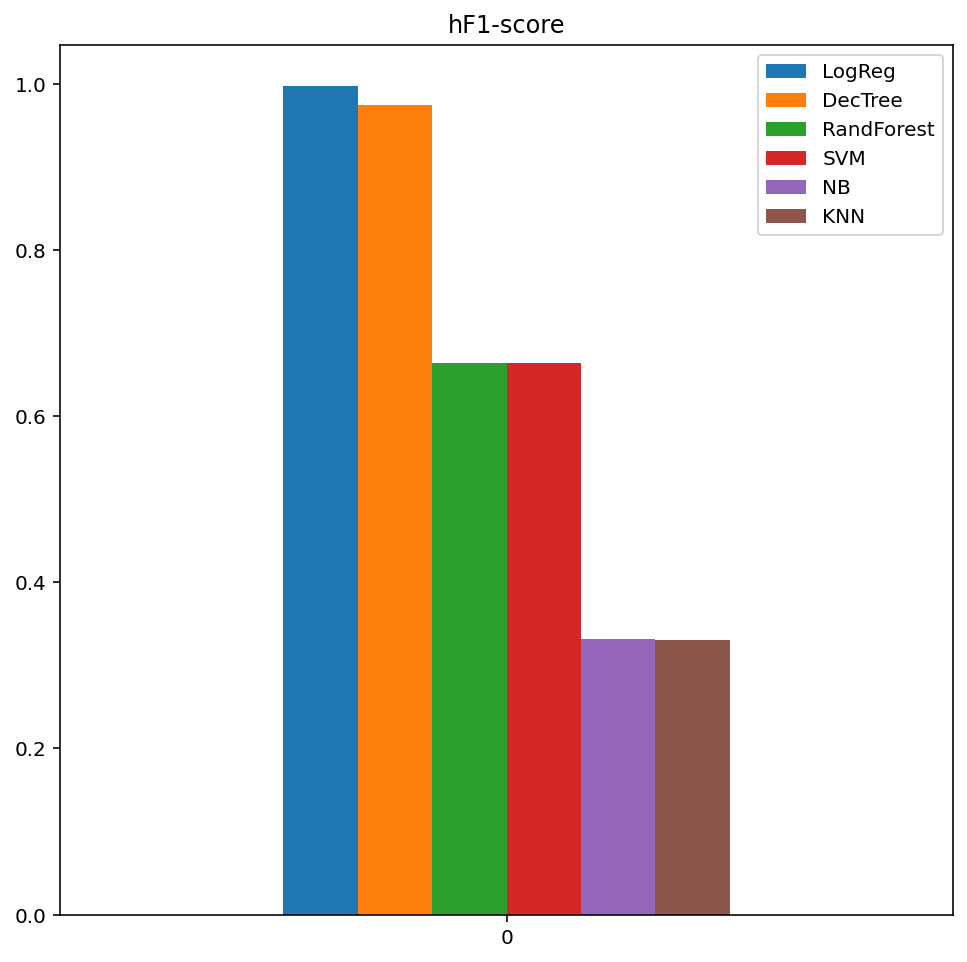

In [87]:
pd.DataFrame([results_hF1]).plot(y=['LogReg', 'DecTree', 'RandForest', 'SVM', 'NB', 'KNN'],
                                 kind='bar',
                                 rot=0,
                                 figsize=(8,8),
                                 title='hF1-score')

Согласно полученным графикам можно сделать вывод, что по метрике иерархического F1, модель логистической регрессии справилась лучше других моделей справилась с поставленной задачей, на втором месте модель решающего дерева, остальные же модели показали себя гораздо хуже, хотя при стандартной оценке метрикой F1 модели не имели таких сильных различий в результатах.

**Направления для дальнейшего исследования:**

* Использование другого подхода к решению задачи иерархической классификации(например использовать классификатор для каждого уровня или классификатор для каждой вершины)
* использовать дополнительный неразмеченный набор данных `unlabeled_150k.csv` с отзывами на различные товары для дополнительного тюнинга моделей
* выполнить дополнительную предобработку текстовых данных (например стемминг или лемматизацию)